In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

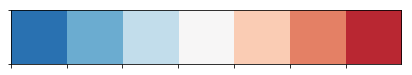

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Base com todas chuvas EXTREMAS com inicio e fim de cada chuva extrema (> 50mm em 24 horas)</p>

In [6]:
dfhr = pd.read_csv('../data/extreme_prcp_evolution.csv')
print len(dfhr)

31710


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [7]:
dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv', index_col=0)
print len(dfext)

761040


# Pré-processamento

<h3>Limpeza dos dados</h3>

In [8]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [9]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [10]:
dfcont = dfcont.apply(pd.to_numeric, errors='coerce')  

In [11]:
dfcont.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 1.2 GB


In [12]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,1407984.0,0.936654,2.923291,0.0,0.0,0.000,0.6,100.000
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.200,973.1,1050.000
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.400,973.3,1050.000
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.900,972.8,1050.000
gbrd,5670348.0,1176.371062,1138.753521,0.0,65.0,863.427,2103.0,11586.491
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.400,24.9,44.900
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.100,18.9,42.700
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.900,25.8,45.000
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.600,19.4,44.800
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.800,24.2,45.000


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [13]:
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [14]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [15]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [16]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


<p>A temperatura será inputada pela média</p>

In [17]:
MEAN = ['temp','dewp']

In [18]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())

In [19]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


In [20]:
for v in ['tmax','tmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['temp'])
    df[v] = df[v].fillna(value=df['temp'])
for v in ['dmax','dmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['dewp'])
    df[v] = df[v].fillna(value=df['dewp'])
for v in ['hmax','hmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['hmdy'])
    df[v] = df[v].fillna(value=df['hmdy'])

In [21]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9779168.0,14.727113,5.805794,-10.0,12.1,16.1,18.9,42.7
tmin,9779168.0,21.104973,7.545616,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779168.0,19.864112,7.134923,-8.5,17.2,20.8,24.2,45.0
dmin,9779168.0,14.219949,5.777816,-10.0,11.6,15.6,18.4,44.9


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t. Vamos primeiramente derivá-las para depois verificar quais quando massivamente as variávies estão zeradas, o que pode indicar que a estação falhou.</p>

<p>Utilizando um exemplo especifico de uma estação, depois verificamos o conjunto maior</p> 

In [22]:
dfm = df[(df.wsid==329)]
len(dfm)

87456

In [23]:
dfm.index = pd.to_datetime(dfm.mdct)
dfm.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 00:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 01:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 02:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 03:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
CLEAN = ['wsnm','inme','city','prov','mdct','date']
REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.head(5)  

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 04:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
def derive_nth_hour_feature(df, feature, N):  
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = np.nan
    df.loc[:][col_name] = nth_prior_measurements

In [26]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

for feature in dfm.columns:
    if feature not in NON_DER:
        for h in range(1,6):
            derive_nth_hour_feature(dfm, feature, h) 

In [27]:
REMOVE = [u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [28]:
dfm.columns

Index([u'elvt', u'lat', u'lon', u'prcp', u'stp', u'smax', u'smin', u'temp',
       u'tmax', u'tmin', u'dewp', u'dmax', u'dmin', u'hmdy', u'hmax', u'hmin',
       u'wdsp', u'wdct', u'gust', u'stp_1', u'stp_2', u'stp_3', u'stp_4',
       u'stp_5', u'smax_1', u'smax_2', u'smax_3', u'smax_4', u'smax_5',
       u'smin_1', u'smin_2', u'smin_3', u'smin_4', u'smin_5', u'temp_1',
       u'temp_2', u'temp_3', u'temp_4', u'temp_5', u'tmax_1', u'tmax_2',
       u'tmax_3', u'tmax_4', u'tmax_5', u'tmin_1', u'tmin_2', u'tmin_3',
       u'tmin_4', u'tmin_5', u'dewp_1', u'dewp_2', u'dewp_3', u'dewp_4',
       u'dewp_5', u'dmax_1', u'dmax_2', u'dmax_3', u'dmax_4', u'dmax_5',
       u'dmin_1', u'dmin_2', u'dmin_3', u'dmin_4', u'dmin_5', u'hmdy_1',
       u'hmdy_2', u'hmdy_3', u'hmdy_4', u'hmdy_5', u'hmax_1', u'hmax_2',
       u'hmax_3', u'hmax_4', u'hmax_5', u'hmin_1', u'hmin_2', u'hmin_3',
       u'hmin_4', u'hmin_5', u'wdsp_1', u'wdsp_2', u'wdsp_3', u'wdsp_4',
       u'wdsp_5', u'wdct_1', u'wdct_2', u'

In [29]:
dfm = dfm.reset_index(drop=True)

In [30]:
dfm = dfm.dropna()  

In [31]:
dfm.head(5)

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [33]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
CAN_BE_NULL

['wdsp', 'prcp', 'gust']

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [35]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','wdsp_1','wdsp_2','wdsp_3','wdsp_4','wdsp_5',\
                'gust','gust_1','gust_2','gust_3','gust_4','gust_5']
for v in COLS_BE_NULL:
    cols.remove(v)

In [36]:
dfm[cols] = dfm[cols].replace({0.0:np.nan})
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [37]:
dfm = dfm.dropna()

In [38]:
len(dfm)

86007

In [39]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


In [40]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,86007.0,0.200865,1.632529,0.0,0.0,0.0,0.0,78.4
stp,86007.0,919.116980,3.190611,906.5,916.9,919.0,921.2,931.4
smax,86007.0,919.358709,3.171215,906.7,917.2,919.2,921.5,931.5
smin,86007.0,918.874314,3.199579,906.4,916.7,918.7,921.0,931.2
temp,86007.0,21.897662,3.927088,8.1,19.2,21.6,24.6,37.0
tmax,86007.0,14.566931,3.529708,-6.3,12.2,15.0,17.4,25.5
tmin,86007.0,22.572387,4.097611,8.7,19.7,22.2,25.5,37.7
dewp,86007.0,15.120801,3.520662,-1.7,12.7,15.6,17.9,23.6
dmax,86007.0,21.243377,3.753360,7.4,18.8,21.0,23.8,35.1
dmin,86007.0,14.039955,3.583685,-6.5,11.7,14.5,16.9,21.6


<h3>Balanceamento</h3>

<p>Preparação para o balanceamento</p>

In [41]:
from imblearn.under_sampling import ClusterCentroids

In [42]:
def f(x):
    if x['prcp'] == 0.0: 
        return 0
    else:        
        return 1    

In [43]:
dfm['type'] = dfm.apply(f,axis=1)

In [44]:
dfm.head(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5,type
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8,0
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8,0
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3,0


In [45]:
#Criando bins sem chuva(0mm), com poquisima chuva( até 0.1mm), chuva fraca (> 0.1 até 1.0) \
#e depois agrupando de 5 em 
#bins = np.linspace(dfm.prcp.min(), dfm.prcp.max(), 10)
#bins = [0,0.1,1,5,10,15,20,25,30] 
#types = np.digitize(dfm.prcp, bins)  
#dfm['type'] = types

In [46]:
z = dfm['type'].groupby(dfm['type']).count()
print (z)

type
0    80270
1     5737
Name: type, dtype: int64


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [47]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [48]:
#dfm = dfm.drop('prcp',1)

In [49]:
target = 'type'

In [50]:
X = dfm[[col for col in dfm.columns if col != target]]

In [51]:
y = dfm[target]

In [52]:
X.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


<p>Separando o conjunto de treinamento e validação (metade dos 30% separados para validação)</p>

In [53]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=12) 

<p>Executando o balanceamento</p>

In [54]:
from sklearn.decomposition import PCA

In [55]:
pca = PCA(n_components=2)

In [56]:
X_vis = pca.fit_transform(X_train)

In [57]:
len(X_train)

60204

In [58]:
cc = ClusterCentroids()
X_resampled, y_resampled = cc.fit_sample(X_train, y_train)
X_res_vis_soft = pca.transform(X_resampled)

In [59]:
len(X_resampled)

7988

In [60]:
cc = ClusterCentroids(voting='hard')
X_resampled, y_resampled = cc.fit_sample(X_train, y_train)
X_res_vis_hard = pca.transform(X_resampled)

In [61]:
len(X_resampled)

7988

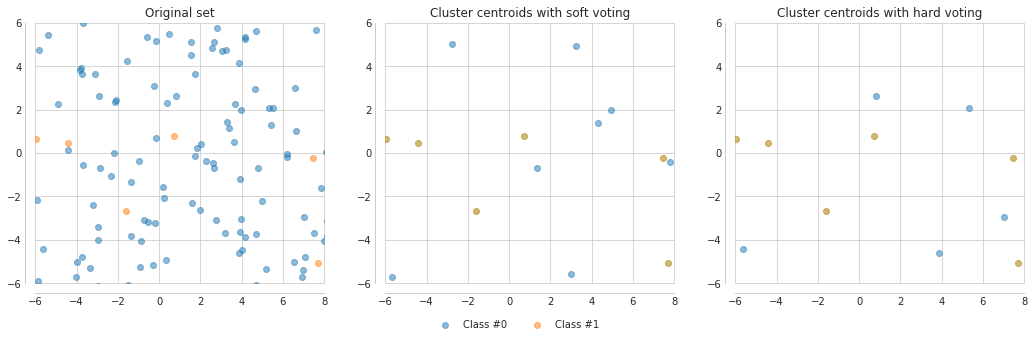

In [62]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

c0 = ax1.scatter(X_vis[y_train== 0, 0], X_vis[y_train== 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y_train== 1, 0], X_vis[y_train== 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis_soft[y_resampled == 0, 0],
            X_res_vis_soft[y_resampled == 0, 1],
            label="Class #0", alpha=.5)
ax2.scatter(X_res_vis_soft[y_resampled == 1, 0],
            X_res_vis_soft[y_resampled == 1, 1],
            label="Class #1", alpha=.5)
c2 = ax2.scatter(X_vis[y_train== 1, 0],
                 X_vis[y_train== 1, 1], label="Original #1",
                 alpha=0.2)
ax2.set_title('Cluster centroids with soft voting')

ax3.scatter(X_res_vis_hard[y_resampled == 0, 0],
            X_res_vis_hard[y_resampled == 0, 1],
            label="Class #0", alpha=.5)
ax3.scatter(X_res_vis_hard[y_resampled == 1, 0],
            X_res_vis_hard[y_resampled == 1, 1],
            label="Class #1", alpha=.5)
ax3.scatter(X_vis[y_train== 1, 0],
            X_vis[y_train== 1, 1],
            alpha=0.2)
ax3.set_title('Cluster centroids with hard voting')

# make nice plotting
for ax in (ax1, ax2, ax3):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

plt.figlegend((c0, c1), ('Class #0', 'Class #1', 'Original Class #1'),
              loc='lower center',
              ncol=3, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

In [63]:
#X_train_over, y_train_over =  SMOTE(random_state=12).fit_sample(X_train, y_train)

In [64]:
len(X_resampled), len(y_resampled)

(7988, 7988)

<p>Reconstruindo o dataframe</p>

In [65]:
#X_train = pd.DataFrame(X_train_over, columns = X_train.columns)
X_train = pd.DataFrame(X_resampled, columns = X_train.columns)

In [66]:
#y_train = pd.DataFrame(y_train_over, columns =['type'])
y_train = pd.DataFrame(y_resampled, columns =['type'])

In [67]:
X_train.head()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
0,0.0,911.7,912.1,911.7,19.3,18.8,19.7,19.3,19.1,18.6,...,188.0,129.0,69.0,121.0,126.0,1.7,1.7,2.1,2.2,2.2
1,0.0,916.5,916.6,916.4,22.2,14.6,22.5,14.7,22.0,14.6,...,99.0,98.0,113.0,106.0,88.0,5.5,4.5,4.4,5.8,6.3
2,0.0,914.9,915.3,914.9,22.7,17.1,23.4,17.6,22.5,16.6,...,327.0,315.0,301.0,314.0,319.0,9.8,9.1,10.4,9.1,5.8
3,0.0,919.1,919.8,919.1,28.2,15.8,28.9,17.4,26.7,14.8,...,56.0,72.0,91.0,107.0,97.0,7.4,5.6,6.0,6.3,4.8
4,0.0,917.0,917.0,916.8,22.1,10.8,22.1,12.5,21.7,10.8,...,228.0,234.0,232.0,249.0,242.0,11.4,11.3,11.2,8.2,8.3


<p>Reconstruindo o datafram para alimnar o tensorflow</p>

In [69]:
y_train['prcp'] = X_train['prcp']
y_tmp = X_tmp['prcp']

In [70]:
y_train = y_train.drop('type',1)

In [71]:
X_train = X_train.drop('prcp',1)
X_tmp = X_tmp.drop('prcp',1)

In [72]:
X_tmp.head(3)

,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
65978,919.5,919.8,919.4,19.7,18.0,21.9,18.2,19.6,16.7,90.0,...,146.0,50.0,130.0,122.0,331.0,7.8,2.8,4.4,4.4,2.5
38040,915.7,915.7,915.1,25.7,17.3,26.4,17.5,25.7,17.0,60.0,...,79.0,97.0,81.0,69.0,108.0,5.6,8.4,9.4,8.9,10.0
68328,924.1,924.1,923.4,14.6,13.7,14.9,13.8,14.6,13.6,94.0,...,83.0,105.0,9.0,20.0,31.0,4.5,3.2,1.8,3.3,3.1


<p>Separando o conjunto de testes</p>

In [73]:
target = 'prcp'

In [74]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [75]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   7988, Training features   90
Validation instances 12902, Validation features 90
Testing instances    12901, Testing features    90


In [81]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [82]:
up

7

In [83]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X_train.columns] 

In [84]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[st_units,sd_units],
                                     # activation_fn=activation_fn,
                                      model_dir='/tmp/tf_wx_model-17')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f99be0369d0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_wx_model-17', '_save_summary_steps': 100}


In [85]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [86]:
evaluations = []  
STEPS = 500  
for i in range(1, 50):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:loss = 4953262.0, step = 1
INFO:tensorflow:global_step/sec: 10.8461
INFO:tensorflow:loss = 45443.03, step = 101 (9.222 sec)
INFO:tensorflow:global_step/sec: 10.8493
INFO:tensorflow:loss = 17500.043, step = 201 (9.217 sec)
INFO:tensorflow:global_step/sec: 11.4325
INFO:tensorflow:loss = 27013.578, step = 301 (8.746 sec)
INFO:tensorflow:global_step/sec: 11.0791
INFO:tensorflow:loss = 19363.81, step = 401 (9.026 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:Loss for final step: 26462.518.
INFO:tensorflow:Starting evaluation at 2018-02-17-12:53:12
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-500
INFO:tensorflow:Finished evaluation at 2018-02-17-12:53:13
INFO:tensorflow:Saving dict for global step 500: average_loss = 10.588899, global_step = 500, loss = 10509.074
INFO:tensor

INFO:tensorflow:Starting evaluation at 2018-02-17-12:59:02
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-4000
INFO:tensorflow:Finished evaluation at 2018-02-17-12:59:04
INFO:tensorflow:Saving dict for global step 4000: average_loss = 2.6692803, global_step = 4000, loss = 2649.158
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-4000
INFO:tensorflow:Saving checkpoints for 4001 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:loss = 28962.662, step = 4001
INFO:tensorflow:global_step/sec: 11.307
INFO:tensorflow:loss = 8615.121, step = 4101 (8.846 sec)
INFO:tensorflow:global_step/sec: 11.4369
INFO:tensorflow:loss = 20396.223, step = 4201 (8.743 sec)
INFO:tensorflow:global_step/sec: 11.1579
INFO:tensorflow:loss = 8940.09, step = 4301 (8.962 sec)
INFO:tensorflow:global_step/sec: 11.0393
INFO:tensorflow:loss = 26819.572, step = 4401 (9.059 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /t

INFO:tensorflow:global_step/sec: 11.498
INFO:tensorflow:loss = 26374.363, step = 7701 (8.695 sec)
INFO:tensorflow:global_step/sec: 11.1097
INFO:tensorflow:loss = 1898.3762, step = 7801 (9.001 sec)
INFO:tensorflow:global_step/sec: 11.4742
INFO:tensorflow:loss = 26035.434, step = 7901 (8.715 sec)
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:Loss for final step: 3015.2734.
INFO:tensorflow:Starting evaluation at 2018-02-17-13:05:43
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-8000
INFO:tensorflow:Finished evaluation at 2018-02-17-13:05:44
INFO:tensorflow:Saving dict for global step 8000: average_loss = 2.6595461, global_step = 8000, loss = 2639.4973
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-8000
INFO:tensorflow:Saving checkpoints for 8001 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:loss = 15492.8125, step = 8001
INFO:tensorflow:

INFO:tensorflow:Saving dict for global step 11500: average_loss = 4.500011, global_step = 11500, loss = 4466.088
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-11500
INFO:tensorflow:Saving checkpoints for 11501 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:loss = 19662.887, step = 11501
INFO:tensorflow:global_step/sec: 10.8568
INFO:tensorflow:loss = 1258.9736, step = 11601 (9.213 sec)
INFO:tensorflow:global_step/sec: 11.2191
INFO:tensorflow:loss = 25674.8, step = 11701 (8.914 sec)
INFO:tensorflow:global_step/sec: 11.2294
INFO:tensorflow:loss = 2387.4766, step = 11801 (8.905 sec)
INFO:tensorflow:global_step/sec: 10.8424
INFO:tensorflow:loss = 22225.404, step = 11901 (9.223 sec)
INFO:tensorflow:Saving checkpoints for 12000 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:Loss for final step: 1659.3174.
INFO:tensorflow:Starting evaluation at 2018-02-17-13:12:23
INFO:tensorflow:Restoring parameters from /tmp/t

INFO:tensorflow:global_step/sec: 10.8973
INFO:tensorflow:loss = 21956.41, step = 15301 (9.177 sec)
INFO:tensorflow:global_step/sec: 11.1878
INFO:tensorflow:loss = 1633.2722, step = 15401 (8.938 sec)
INFO:tensorflow:Saving checkpoints for 15500 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:Loss for final step: 22852.963.
INFO:tensorflow:Starting evaluation at 2018-02-17-13:18:15
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-15500
INFO:tensorflow:Finished evaluation at 2018-02-17-13:18:16
INFO:tensorflow:Saving dict for global step 15500: average_loss = 4.5782, global_step = 15500, loss = 4543.6875
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-15500
INFO:tensorflow:Saving checkpoints for 15501 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:loss = 9667.433, step = 15501
INFO:tensorflow:global_step/sec: 10.9468
INFO:tensorflow:loss = 18944.984, step = 15601 (9.137 sec)
INFO:tensor

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-19000
INFO:tensorflow:Saving checkpoints for 19001 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:loss = 1117.6537, step = 19001
INFO:tensorflow:global_step/sec: 10.296
INFO:tensorflow:loss = 23276.143, step = 19101 (9.714 sec)
INFO:tensorflow:global_step/sec: 11.0161
INFO:tensorflow:loss = 1526.6014, step = 19201 (9.078 sec)
INFO:tensorflow:global_step/sec: 11.2857
INFO:tensorflow:loss = 27924.846, step = 19301 (8.861 sec)
INFO:tensorflow:global_step/sec: 11.1858
INFO:tensorflow:loss = 3266.418, step = 19401 (8.939 sec)
INFO:tensorflow:Saving checkpoints for 19500 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:Loss for final step: 30485.746.
INFO:tensorflow:Starting evaluation at 2018-02-17-13:24:59
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-19500
INFO:tensorflow:Finished evaluation at 2018-02-17-13:25:00
INFO:tensorflow:Saving 

INFO:tensorflow:global_step/sec: 11.2063
INFO:tensorflow:loss = 1574.3345, step = 22901 (8.923 sec)
INFO:tensorflow:Saving checkpoints for 23000 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:Loss for final step: 25092.812.
INFO:tensorflow:Starting evaluation at 2018-02-17-13:30:51
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-23000
INFO:tensorflow:Finished evaluation at 2018-02-17-13:30:53
INFO:tensorflow:Saving dict for global step 23000: average_loss = 4.1818533, global_step = 23000, loss = 4150.3286
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-23000
INFO:tensorflow:Saving checkpoints for 23001 into /tmp/tf_wx_model-17/model.ckpt.
INFO:tensorflow:loss = 3080.5227, step = 23001
INFO:tensorflow:global_step/sec: 11.2304
INFO:tensorflow:loss = 16530.629, step = 23101 (8.906 sec)
INFO:tensorflow:global_step/sec: 11.3759
INFO:tensorflow:loss = 1674.802, step = 23201 (8.790 sec)
INFO:te

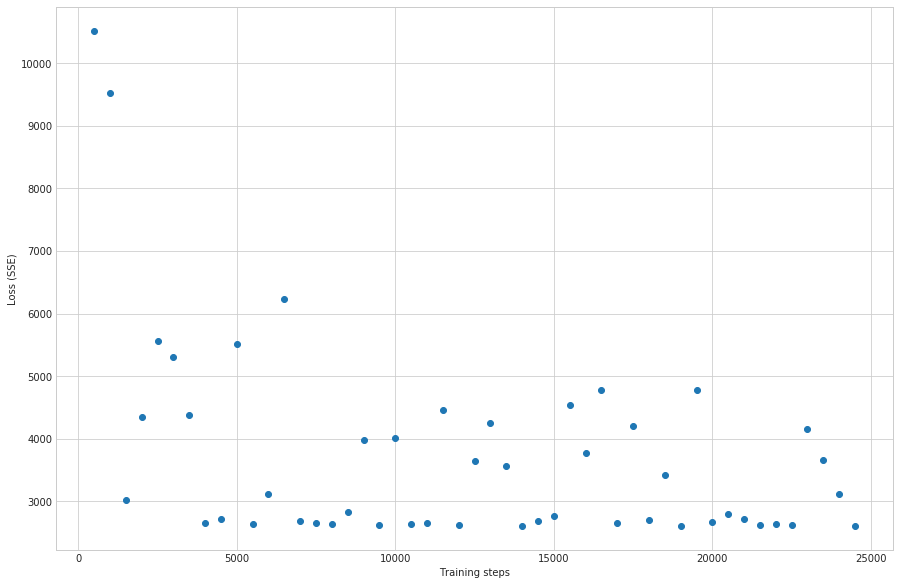

In [87]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [88]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-17/model.ckpt-24500


In [89]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f mm " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f mm" % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: -0.01
The Mean Absolute Error: 0.94 mm 
The Median Absolute Error: 0.69 mm


In [90]:
predictions

array([-0.0724452 ,  0.8645322 , -1.3304026 , ...,  1.1862028 ,
        0.6056401 , -0.20254163], dtype=float32)

In [91]:
predictions.size

12901

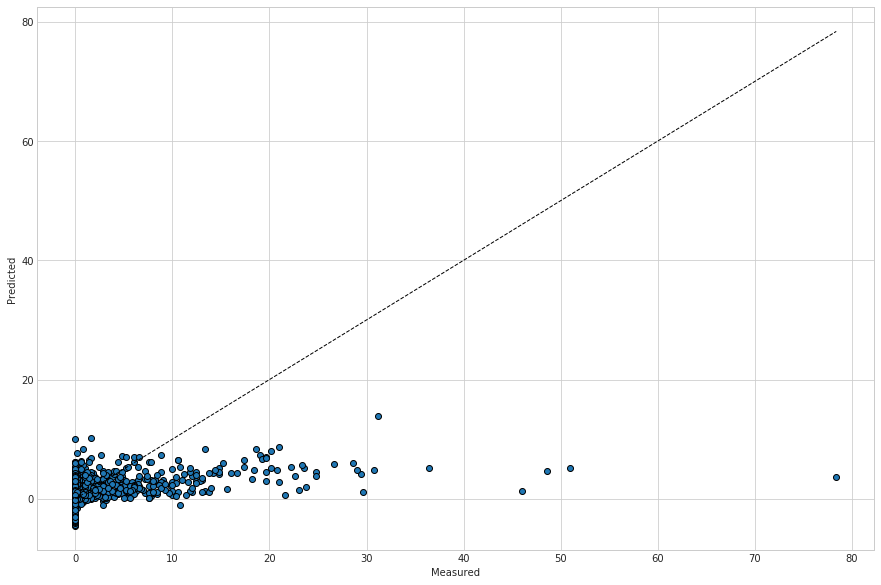

In [92]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()